In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

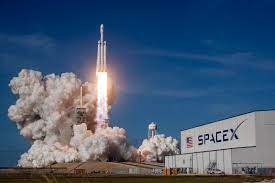

In [2]:
data = pd.read_csv('../input/space-x-launches-falcon9-and-falcon-heavy/Falcon 9 and Falcon Heavy launches .csv')

In [3]:
data.head(5)

In [4]:
data.info()

# Let me see what do we actually have in our dataset.

In [5]:
from pandas_profiling import ProfileReport
profile = ProfileReport(data, title="Profiling Report SPACEX",explorative=True)
profile.to_notebook_iframe()

In [6]:
pip install sweetviz

In [7]:
import sweetviz as sv
my_report = sv.analyze([data,"Parameters"])
my_report.show_notebook()

In [8]:
from sklearn.preprocessing import LabelEncoder
le_VB = LabelEncoder()
le_LS = LabelEncoder()
le_payload = LabelEncoder()
le_payload_mass = LabelEncoder()
le_orbit = LabelEncoder()
le_customer = LabelEncoder()
le_LO = LabelEncoder()
le_BL = LabelEncoder()

In [9]:
data['Version, Booster_n'] = le_VB.fit_transform(data['Version, Booster'])
data['Launch_Site_n'] = le_LS.fit_transform(data['Launch_Site'])
data['Payload_n'] = le_payload.fit_transform(data['Payload'])
data['Payload_Mass_n'] = le_payload_mass.fit_transform(data['Payload_Mass'])
data['Orbit_n'] = le_orbit.fit_transform(data['Orbit'])
data['Customer_n'] = le_customer.fit_transform(data['Customer'])
data['Launch_Outcome_n'] = le_LO.fit_transform(data['Launch_Outcome'])
data['Booster_landing_n'] = le_BL.fit_transform(data['Booster_landing'])

In [10]:
data['Launch_Site_n'].value_counts()

In [11]:
data['Launch_Site'].value_counts()

In [12]:
data.info()

In [13]:
data.Booster_landing_n.value_counts()

In [14]:
data.Booster_landing.value_counts()

In [15]:
data.Launch_Outcome_n.value_counts()

In [16]:
data.Launch_Outcome.value_counts()

In [17]:
# Let's drop other columns
data.drop(data.columns[[3,4,5,6,7,8,9,10,11]],axis=1,inplace=True)

In [18]:
data.info()

In [19]:
from pandas import datetime

In [20]:
data.Date

In [21]:
plt.plot(data.Date,data.Launch_Outcome_n)
plt.show()

In [22]:
plt.plot(data.Date,data.Booster_landing_n)
plt.show()

In [23]:
data['Date'] = data.Date.apply(lambda x: pd.to_datetime(x).strftime('%d-%m-%Y'))

In [24]:
data['Date'] = pd.to_datetime(data['Date'],format='%d-%m-%Y')

In [25]:
Date = data['Date']
Date

In [26]:
# This is how I want my data to look like.
profile2 = ProfileReport(data, title="Profiling Report SPACEX",explorative=True)
profile2.to_notebook_iframe()

In [27]:
my_report = sv.analyze([data,"Parameters"])
my_report.show_notebook()

In [28]:
# Date is creating some problem during ML , so i dicided it to drop.
data.drop('Date',axis=1,inplace=True)

In [29]:
x = data.drop(['Launch_Outcome_n','Booster_landing_n'],axis=1)
x

# Now, Let's get down to ML

In [30]:
y = data[['Launch_Outcome_n','Booster_landing_n']]
y.head()

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=42)

In [32]:
y_train.nunique()

In [33]:
y_test.nunique()

In [34]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
classifier = MultiOutputClassifier(knn)
classifier.fit(X_train,y_train)
classifier.score(X_test,y_test)

In [35]:
from sklearn.ensemble import RandomForestClassifier
r_model = RandomForestClassifier()
r_model_m = MultiOutputClassifier(r_model)
r_model_m.fit(X_train,y_train)
r_model_m.score(X_test,y_test)

In [36]:
from sklearn.svm import SVC
s_model = SVC()
s_model_m = MultiOutputClassifier(s_model)
s_model_m.fit(X_train,y_train)
s_model_m.score(X_test,y_test)

In [37]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=5)
dt = MultiOutputClassifier(dt)
dt.fit(X_train, y_train) # Train model
dt.score(X_test,y_test)

In [38]:
from sklearn.neural_network import MLPClassifier

mlp = MultiOutputClassifier(MLPClassifier(alpha=1, max_iter=1000))
mlp.fit(X_train, y_train)
mlp.score(X_test,y_test)

In [39]:
from sklearn.model_selection import GridSearchCV
fm = GridSearchCV(SVC(gamma='auto'),{
    
    'C' : [10,15,20,25,30],
    'kernel' : ['linear','rbf']
} , cv = 5)
fm_m = MultiOutputClassifier(fm)
fm_m.fit(X_train,y_train)
fm_m.score(X_test,y_test)

In [40]:
from sklearn.model_selection import RandomizedSearchCV
rs = RandomizedSearchCV(SVC(gamma='auto'), {
        'C': [1,10,20],
        'kernel': ['rbf','linear']
    }, 
    cv=5, 
    return_train_score=False, 
    n_iter=2
)
rs_m = MultiOutputClassifier(rs)
rs_m.fit(X_train,y_train)
rs_m.score(X_test,y_test)

In [41]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
MultiOutputRegressor(GradientBoostingRegressor(random_state=42)).fit(X_train, y_train).score(X_test,y_test)

In [42]:
from sklearn.svm import LinearSVC
MultiOutputRegressor(LinearSVC(random_state=42)).fit(X_train, y_train).score(X_test,y_test)

In [43]:
pip install autogluon

In [44]:
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.common.utils.utils import setup_outputdir
from autogluon.core.utils.loaders import load_pkl
from autogluon.core.utils.savers import save_pkl
import os.path

class MultilabelPredictor():
    """ Tabular Predictor for predicting multiple columns in table.
        Creates multiple TabularPredictor objects which you can also use individually.
        You can access the TabularPredictor for a particular label via: `multilabel_predictor.get_predictor(label_i)`

        Parameters
        ----------
        labels : List[str]
            The ith element of this list is the column (i.e. `label`) predicted by the ith TabularPredictor stored in this object.
        path : str, default = None
            Path to directory where models and intermediate outputs should be saved.
            If unspecified, a time-stamped folder called "AutogluonModels/ag-[TIMESTAMP]" will be created in the working directory to store all models.
            Note: To call `fit()` twice and save all results of each fit, you must specify different `path` locations or don't specify `path` at all.
            Otherwise files from first `fit()` will be overwritten by second `fit()`.
            Caution: when predicting many labels, this directory may grow large as it needs to store many TabularPredictors.
        problem_types : List[str], default = None
            The ith element is the `problem_type` for the ith TabularPredictor stored in this object.
        eval_metrics : List[str], default = None
            The ith element is the `eval_metric` for the ith TabularPredictor stored in this object.
        consider_labels_correlation : bool, default = True
            Whether the predictions of multiple labels should account for label correlations or predict each label independently of the others.
            If True, the ordering of `labels` may affect resulting accuracy as each label is predicted conditional on the previous labels appearing earlier in this list (i.e. in an auto-regressive fashion).
            Set to False if during inference you may want to individually use just the ith TabularPredictor without predicting all the other labels.
        kwargs :
            Arguments passed into the initialization of each TabularPredictor.

    """

    multi_predictor_file = 'multilabel_predictor.pkl'

    def __init__(self, labels, path=None, problem_types=None, eval_metrics=None, consider_labels_correlation=True, **kwargs):
        if len(labels) < 2:
            raise ValueError("MultilabelPredictor is only intended for predicting MULTIPLE labels (columns), use TabularPredictor for predicting one label (column).")
        if (problem_types is not None) and (len(problem_types) != len(labels)):
            raise ValueError("If provided, `problem_types` must have same length as `labels`")
        if (eval_metrics is not None) and (len(eval_metrics) != len(labels)):
            raise ValueError("If provided, `eval_metrics` must have same length as `labels`")
        self.path = setup_outputdir(path, warn_if_exist=False)
        self.labels = labels
        self.consider_labels_correlation = consider_labels_correlation
        self.predictors = {}  # key = label, value = TabularPredictor or str path to the TabularPredictor for this label
        if eval_metrics is None:
            self.eval_metrics = {}
        else:
            self.eval_metrics = {labels[i] : eval_metrics[i] for i in range(len(labels))}
        problem_type = None
        eval_metric = None
        for i in range(len(labels)):
            label = labels[i]
            path_i = self.path + "Predictor_" + label
            if problem_types is not None:
                problem_type = problem_types[i]
            if eval_metrics is not None:
                eval_metric = eval_metrics[i]
            self.predictors[label] = TabularPredictor(label=label, problem_type=problem_type, eval_metric=eval_metric, path=path_i, **kwargs)

    def fit(self, train_data, tuning_data=None, **kwargs):
        """ Fits a separate TabularPredictor to predict each of the labels.

            Parameters
            ----------
            train_data, tuning_data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                See documentation for `TabularPredictor.fit()`.
            kwargs :
                Arguments passed into the `fit()` call for each TabularPredictor.
        """
        if isinstance(train_data, str):
            train_data = TabularDataset(train_data)
        if tuning_data is not None and isinstance(tuning_data, str):
            tuning_data = TabularDataset(tuning_data)
        train_data_og = train_data.copy()
        if tuning_data is not None:
            tuning_data_og = tuning_data.copy()
        else:
            tuning_data_og = None
        save_metrics = len(self.eval_metrics) == 0
        for i in range(len(self.labels)):
            label = self.labels[i]
            predictor = self.get_predictor(label)
            if not self.consider_labels_correlation:
                labels_to_drop = [l for l in self.labels if l != label]
            else:
                labels_to_drop = [self.labels[j] for j in range(i+1, len(self.labels))]
            train_data = train_data_og.drop(labels_to_drop, axis=1)
            if tuning_data is not None:
                tuning_data = tuning_data_og.drop(labels_to_drop, axis=1)
            print(f"Fitting TabularPredictor for label: {label} ...")
            predictor.fit(train_data=train_data, tuning_data=tuning_data, **kwargs)
            self.predictors[label] = predictor.path
            if save_metrics:
                self.eval_metrics[label] = predictor.eval_metric
        self.save()

    def predict(self, data, **kwargs):
        """ Returns DataFrame with label columns containing predictions for each label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to make predictions for. If label columns are present in this data, they will be ignored. See documentation for `TabularPredictor.predict()`.
            kwargs :
                Arguments passed into the predict() call for each TabularPredictor.
        """
        return self._predict(data, as_proba=False, **kwargs)

    def predict_proba(self, data, **kwargs):
        """ Returns dict where each key is a label and the corresponding value is the `predict_proba()` output for just that label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to make predictions for. See documentation for `TabularPredictor.predict()` and `TabularPredictor.predict_proba()`.
            kwargs :
                Arguments passed into the `predict_proba()` call for each TabularPredictor (also passed into a `predict()` call).
        """
        return self._predict(data, as_proba=True, **kwargs)

    def evaluate(self, data, **kwargs):
        """ Returns dict where each key is a label and the corresponding value is the `evaluate()` output for just that label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to evalate predictions of all labels for, must contain all labels as columns. See documentation for `TabularPredictor.evaluate()`.
            kwargs :
                Arguments passed into the `evaluate()` call for each TabularPredictor (also passed into the `predict()` call).
        """
        data = self._get_data(data)
        eval_dict = {}
        for label in self.labels:
            print(f"Evaluating TabularPredictor for label: {label} ...")
            predictor = self.get_predictor(label)
            eval_dict[label] = predictor.evaluate(data, **kwargs)
            if self.consider_labels_correlation:
                data[label] = predictor.predict(data, **kwargs)
        return eval_dict

    def save(self):
        """ Save MultilabelPredictor to disk. """
        for label in self.labels:
            if not isinstance(self.predictors[label], str):
                self.predictors[label] = self.predictors[label].path
        save_pkl.save(path=self.path+self.multi_predictor_file, object=self)
        print(f"MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('{self.path}')")

    @classmethod
    def load(cls, path):
        """ Load MultilabelPredictor from disk `path` previously specified when creating this MultilabelPredictor. """
        path = os.path.expanduser(path)
        if path[-1] != os.path.sep:
            path = path + os.path.sep
        return load_pkl.load(path=path+cls.multi_predictor_file)

    def get_predictor(self, label):
        """ Returns TabularPredictor which is used to predict this label. """
        predictor = self.predictors[label]
        if isinstance(predictor, str):
            return TabularPredictor.load(path=predictor)
        return predictor

    def _get_data(self, data):
        if isinstance(data, str):
            return TabularDataset(data)
        return data.copy()

    def _predict(self, data, as_proba=False, **kwargs):
        data = self._get_data(data)
        if as_proba:
            predproba_dict = {}
        for label in self.labels:
            print(f"Predicting with TabularPredictor for label: {label} ...")
            predictor = self.get_predictor(label)
            if as_proba:
                predproba_dict[label] = predictor.predict_proba(data, as_multiclass=True, **kwargs)
            data[label] = predictor.predict(data, **kwargs)
        if not as_proba:
            return data[self.labels]
        else:
            return predproba_dict

In [45]:
labels = ['Launch_Outcome_n','Booster_landing_n']  # which columns to predict based on the others
problem_types = ['regression','multiclass']  # type of each prediction problem (optional)
eval_metrics = ['mean_absolute_error','accuracy']  # metrics used to evaluate predictions for each label (optional)
time_limit = 7  # how many seconds to train the TabularPredictor for each label, set much larger in your applications!

In [46]:
multi_predictor = MultilabelPredictor(labels=labels, problem_types=problem_types, eval_metrics=eval_metrics)
multi_predictor.fit(data, time_limit=time_limit)

In [47]:
evaluations = multi_predictor.evaluate(data)
print(evaluations)
print("Evaluated using metrics:", multi_predictor.eval_metrics)

In [48]:
predictions = multi_predictor.predict(data)
print("Predictions:  \n", predictions)

In [49]:
import numpy as np
data_p = pd.DataFrame(np.round(predictions))
type(data_p)

# Here, (nan) represents the number of times the prediction was Right.

In [50]:
data_p['Comparision_l'] = np.where((data_p['Launch_Outcome_n'] != y['Launch_Outcome_n']), y['Launch_Outcome_n'], np.nan)
data_p.head()

In [51]:
correct_l = data_p['Comparision_l'].isna().sum()
correct_l

In [52]:
accuracy_l = ((correct_l)/165) * 100
accuracy_l

In [53]:
print("Accuracy for the Launching Outcome :" , accuracy_l)

In [54]:
data_p['Comparision_b'] = np.where((data_p['Booster_landing_n'] != y['Booster_landing_n']), y['Booster_landing_n'], np.nan)
data_p.head()

In [55]:
correct_b = data_p['Comparision_b'].isna().sum()
correct_b

In [56]:
accuracy_b = ((correct_b)/165) * 100
accuracy_b

In [57]:
print("Accuracy for the Booster Landing Outcome :" , accuracy_b)

In [59]:
data_p['Comparision_lb'] = np.where((data_p['Launch_Outcome_n'] != y['Launch_Outcome_n']) &
                                    (data_p['Booster_landing_n'] != y['Booster_landing_n']), y['Launch_Outcome_n'], np.nan)
data_p.head()

In [60]:
correct_lb = data_p['Comparision_lb'].isna().sum()
correct_lb

In [61]:
accuracy_lb = ((correct_lb)/165) * 100
accuracy_lb

In [62]:
data_p.head(163)

In [63]:
y.head(163)

In [64]:
import sweetviz as sv
actual_values = sv.analyze(y)
actual_values.show_notebook()

In [65]:
import sweetviz as sv
actual_values = sv.analyze(data_p)
actual_values.show_notebook()

# Comapring Both of the reports we can very clearly say that the model is performing pretty well for the prediction of both Launch_Outcome and Booster landing Outcome.